# Building a Neural Network to Classify VLA Sky Survey Objects
## AAS Splinter Session - June 2023

### [Brian R. Kent](https://www.cv.nrao.edu/~bkent/), National Radio Astronomy Observatory ([NRAO](https://science.nrao.edu/))

In this example, we will build a train a simple CNN model to classify image cutouts from the [NRAO VLA Sky Survey](https://vlass.org).

In order to accomplish this, we will use the package [TensorFlow](https://www.tensorflow.org/) to train an augmented [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) (CNN).  This falls under the umbrella of [*deep learning*](https://developer.nvidia.com/deep-learning).

CNNs are useful for examining and classifying images.  This example requires a basic knoweldge of [Python](https://python.org/).

Refer to the paper by [Lacy et al. 2020](https://ui.adsabs.harvard.edu/abs/2020PASP..132c5001L/abstract) for an excellent description of the VLA Sky Survey.

# Overview

* Explain the data preparation and loading
* Examine our VLA Sky Survey images
* Create training and validation sets
* Categorize our classies into a TensorFlow friendly matrix
* Define our model layers with Keras and TensorFlow
* Summarize our model
* Peform data pre-processing with the DataGenerator class
* Compile and fit the model
* Test the model performance
* Visually display the results

# Data Import

The [VLASS images](https://archive-new.nrao.edu/vlass/) have been extracted and gridded into small thumbnails for ease of transfer in this exercise.  The images and their associated labels have been pickled into NumPy arrays.  These files can be opened remotely in this Jupyter notebook session.

Approximately 60,000 VLASS objects are in these data files.

In [ ]:
import numpy as np
import pickle
from urllib.request import urlopen

data_array_file = 'https://www.cv.nrao.edu/~bkent/astro/vlass/vlass_data_array.p'
labels_file = 'https://www.cv.nrao.edu/~bkent/astro/vlass/vlass_labels.p'

data_array = pickle.load(urlopen(data_array_file))
labels = pickle.load(urlopen(labels_file))


In [ ]:
da = data_array.shape
dl = labels.shape
print("{!s} images each of size {!s} x {!s} pixels.".format(da[0],da[1],da[2]))
print("There are {!s} corresponding labels - one category for each image.".format(dl[0]))

61351 images each of size 64 x 64 pixels.
There are 61351 corresponding labels - one category for each image.


We will use 50,000 objects for our training dataset, and the rest for validation.

In [ ]:
cutoff_index = 50000
x_train = data_array[0:cutoff_index, :, :]
y_train = np.array(labels[0:cutoff_index])
x_valid = data_array[cutoff_index+1:, :, :]
y_valid = np.array(labels[cutoff_index+1:])

print("There are {!s} objects for training and {!s} for validation.".format(x_train.shape[0], x_valid.shape[0]))

There are 50000 objects for training and 11350 for validation.


# Examine a training image

Choose an image index and display it with MatplotLib `imshow()`

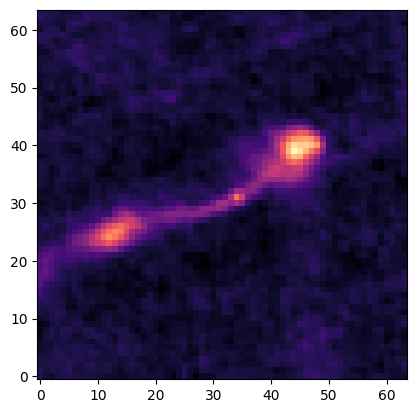

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_train[221], cmap='magma', origin='lower')
plt.grid(False)
plt.show()

# Display a grid of VLASS Objects

Let us use `gridspec` to show a 4 x 8 matrix of VLASS objects.  We have selected indicies of some interesting VLASS radio detections.  Loop over the columns and rows to create a montage of detections.

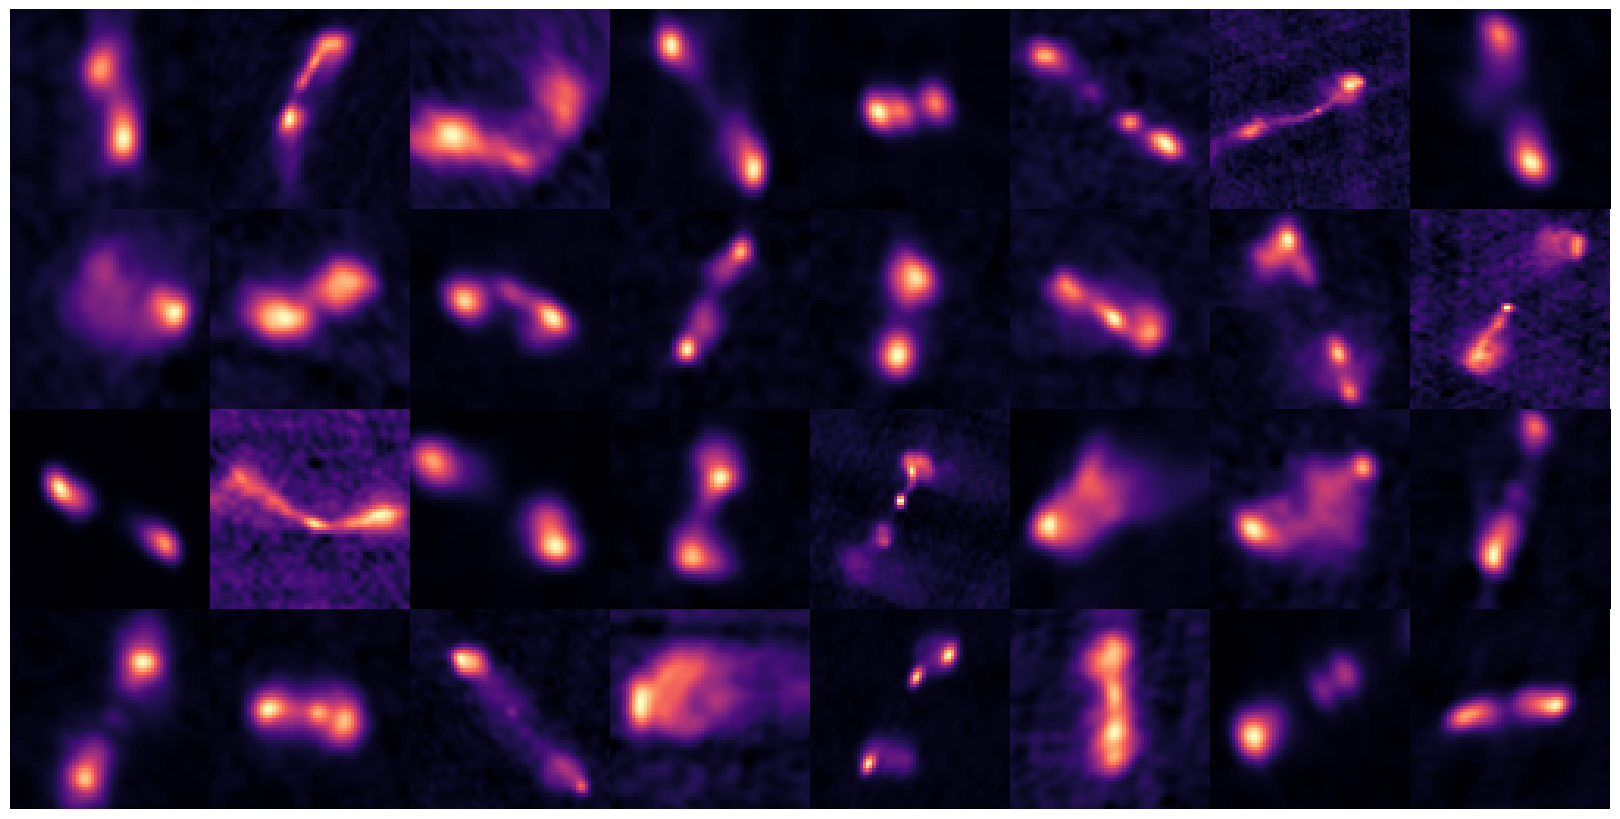

In [ ]:
from matplotlib import gridspec

nrows = 4
ncols = 8

fig = plt.figure(figsize=(2.0 * (ncols + 1), 2.0 * (nrows + 1))) 
batch_size = nrows * ncols

gs = gridspec.GridSpec(nrows, ncols, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1],
                       wspace=0.0, hspace=0.0, top=1.0-0.5/(nrows+1), 
                       bottom=0.5/(nrows+1), left=0.5/(ncols+1), 
                       right=1.0-0.5/(ncols+1)) 

objects = [19,61,67,125,144,202,221,326,366,410,438,472,488,
           532,570,586,619,644,719,762,853,879,910,926,956,
           984,1016,1036,1117,1178,1186,1204]

count = 0
for i in range(nrows):
    for j in range(ncols):
        image = x_train[objects[count]]
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.squeeze(image), origin='lower', cmap='magma')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_axis_off()
        count+=1

plt.show()

# Reshape our Data Arrays

A bit of data formatting is needed to proceed.  TensorFlow can analyze color images like JPEG files with three color channels, so to fit into the expected dimensions of the data model, we will reshape our training and validate arrays by addeding an extra element.  A value of -1 can be passed for a dimension we need to remain unchanged.

In [ ]:
x_train = x_train.reshape(-1,64,64,1)
x_valid = x_valid.reshape(-1,64,64,1)
print("Our training data array is now of shape {!s}".format(x_train.shape))
print("Our validation data array is now of shape {!s}".format(x_valid.shape))

Our training data array is now of shape (50000, 64, 64, 1)
Our validation data array is now of shape (11350, 64, 64, 1)


# Categorize our Classes

We will take our single dimension array of class labels (four types) and categorize them into a matrix using a Keras utility.  This format is expected by TensorFlow, and turns an array like this:

```
[0,1,2,1,1,2,0,2,3,...]
```

into a matrix like this:

```
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)
```

In [ ]:
import tensorflow.keras as keras

num_classes = 4
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Building a Sequential Model

We will import the [Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) that we need to use.  Each layer has exactly one input tensor and one output tensor.

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.
We use a [*Rectilinear Activation Function*](https://arxiv.org/abs/1803.08375) or *ReLu* for our neurons.  This is a go/no-go decision maker - if our input is postive, then the input will pass through - otherwise, zero goes through. 

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/). 

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
Max pooling regrids an image to a lower resolution.  This allows us to perform linear translational shifts and helps the model execute faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
 Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass.  It is a technique for preventing overfitting, a common problem in deep learning and neural network creation. This helps to make sure that the network is robust and redundant, and does not inadvertendly become dependent on a single area to come up with answers for classification.  

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

# Model Summary

We have a lot of layers in this model - the TensorFlow documentation will give details as to their inputs and activation keywords.  This is relatively standard with a lot of boilerplate default settings.

The true research element of building a neural network like this lies in the tuning of these parameters.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 50)       2

# Create a DataGenerator

We can expand our dataset using what we already have.  The Universe does not care about the orientation of galaxies of their size, so we can tell TensorFlow to *augment* our images by rotating, scaling, flipping, and shifting them.

In order to teach our model to be more robust when looking at new data, we're going to programmatically increase the size and variance in our dataset. This is known as [*data augmentation*](https://link.springer.com/article/10.1186/s40537-019-0197-0), a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

Keras comes with an image augmentation class called `ImageDataGenerator`. We recommend checking out the [documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). It accepts a series of options for augmenting your data. Later in the course, we'll have you select a proper augmentation strategy. For now, take a look at the options we've selected below, and then execute the cell to create an instance of the class:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True, # randomly flip images vertically
)  

# Fitting the Data to our new Generator

We need to use two class methods: `flow()` and `fit()`, and pass training arrays as arguments.  We then compile our model.  The resulting image interator created by `flow()` is what we will pass to the model.

We then train the model for 10 epochs.

In [ ]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)
datagen.fit(x_train)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10
1562/1562 [==============================] - 53s 26ms/step - loss: 0.6665 - accuracy: 0.7574 - val_loss: 0.9848 - val_accuracy: 0.7561
Epoch 2/10
1562/1562 [==============================] - 41s 26ms/step - loss: 0.4859 - accuracy: 0.8137 - val_loss: 0.7965 - val_accuracy: 0.7474
Epoch 3/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4585 - accuracy: 0.8233 - val_loss: 0.9170 - val_accuracy: 0.7036
Epoch 4/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4437 - accuracy: 0.8309 - val_loss: 1.1099 - val_accuracy: 0.6879
Epoch 5/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4301 - accuracy: 0.8346 - val_loss: 4.9896 - val_accuracy: 0.2471
Epoch 6/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4195 - accuracy: 0.8386 - val_loss: 0.3726 - val_accuracy: 0.8415
Epoch 7/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4141 - accuracy: 0.8401 - val_loss: 1.9466 -

# Choosing a runtime

We can drastically decrease the execution time for training the model by switching to a GPU runtime (available in Google Colab).

# Model Prediction on an Image

We can use our new, trained model to predict the classification of an image.  The image needs to be reshaped in order to fit the dimensions needed for the `predict()` class.

We also deinfe a dictionary mapping of index to classification type.

In [ ]:
index2type = { 0: 'Extended',
               1: 'Point Source',
               2: 'Double Lobes',
               3: 'Three Points'}

image = x_train[0]
print("The image shape is: {!s}".format(image.shape))
image = image.reshape(1,64,64,1)
print("After reshaping, the image shape is: {!s}".format(image.shape))

The image shape is: (64, 64, 1)
After reshaping, the image shape is: (1, 64, 64, 1)


In [ ]:
prediction = model.predict(image)
print(prediction)

1/1 [==============================] - 0s 27ms/step
[[1.0000000e+00 4.9273115e-26 7.7479750e-16 2.6798130e-10]]


Our prediction returns an array of four numbers.  The first index is *1*, and the rest are near *zero*.  Use our dictionary map to turn this into a human-readable classification.

In [ ]:
print(index2type[np.argmax(prediction)])

Extended


# Displaying the accuracy of our model

How did the model fit perform?  If we compare what the model predicts versus what the actual classification is known to be, we can make a *confusion matrix*.

We can use our training set, pass it to the predictor, and the compare that array to our array of known values.

The `sklearn` package metrics contains `confusion_matrix` and `classification _report` methods that can create a text report.

In [ ]:
test_pred_raw = model.predict(x_train[:,:,:,:])
test_pred = np.argmax(test_pred_raw, axis=1)
y_test = labels[0:cutoff_index]

1563/1563 [==============================] - 4s 3ms/step


In [ ]:
import sklearn
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_pred)
class_names = np.array(list(index2type.values()))

In [ ]:
print(metrics.classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81     10660
           1       0.97      0.92      0.94     21040
           2       0.83      0.79      0.81     13665
           3       0.67      0.25      0.37      4635

    accuracy                           0.84     50000
   macro avg       0.79      0.74      0.73     50000
weighted avg       0.84      0.84      0.82     50000



We will use a boilerplate function to create a graphical view of the confusion matrix.

In [ ]:
import itertools

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)
    #return figure

# Confusion Matrix

The simple plot below shows 16 squares, each comparing the percentage of objects with their true and predicted classification labels.  The colorbar indicated the number of sources in that particular bin, and the numbers indicate the perfectage of sources that were matched between the true and predicted categories.

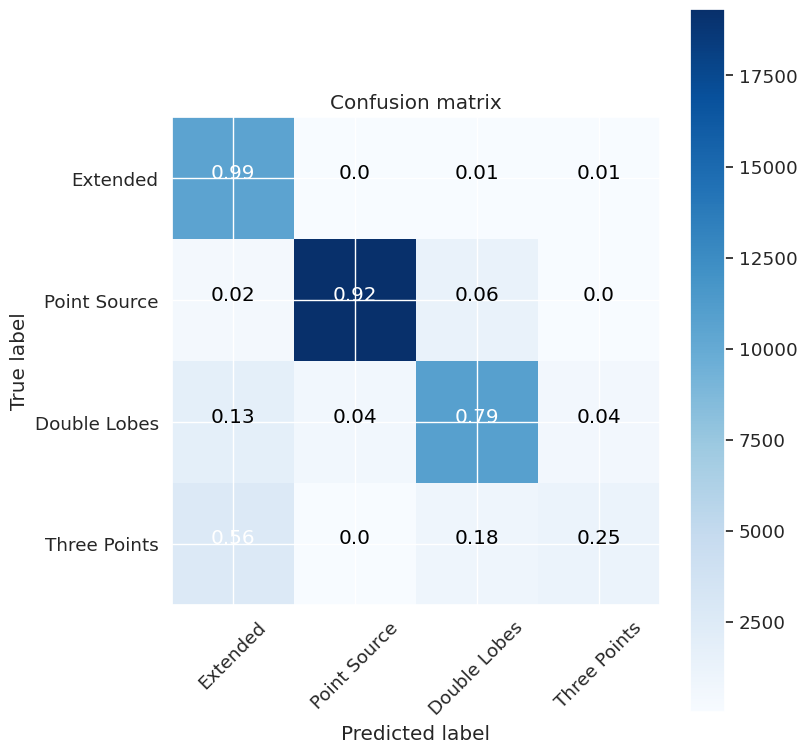

In [ ]:
plot_confusion_matrix(cm, class_names)

# Alternative plotting commands

We can use the nice visualization package seaborn along with a Pandas `DataFrame()` to make a similar type of plot.

Text(43.24999999999999, 0.5, 'True')

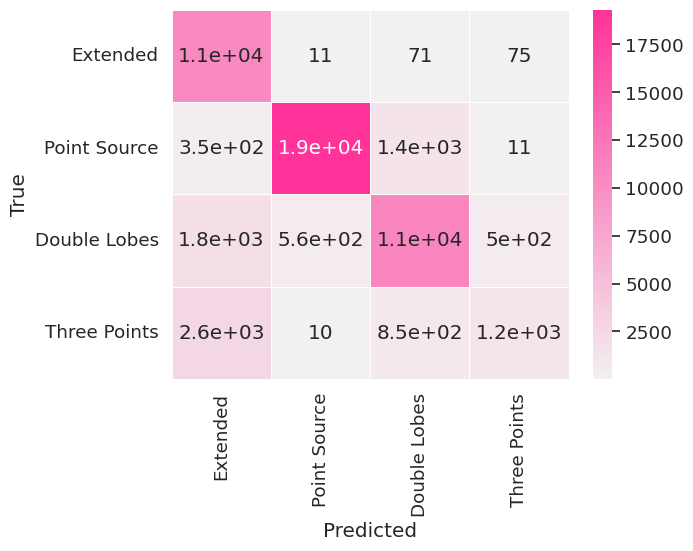

In [ ]:
import seaborn as sns
import pandas as pd
sortedlabels = class_names
cmplot = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cmplot, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

# Summary and References

We have given a basic introduction to creating a neural network for VLASS detection classification with TensorFlow. Review these publications and links for further study.

* [Focus on Machine Intelligence in Astronomy and Astrophysics](https://iopscience.iop.org/journal/1538-3873/page/machine-intelligence-in-astronomy-and-astrophysics)
* [NVidia Deep Learning Institute](https://www.nvidia.com/en-us/training/)
* [TensorFlow Quickstart](https://www.tensorflow.org/tutorials/quickstart/beginner)
* [PyTorch Tutorials](https://pytorch.org/tutorials/)

# Acknowledgements

Thanks to the VLASS team of NRAO scientists, postdocs, data analysts, software engineers, and community members who push this project forward.

The [National Radio Astronomy Observatory](https://science.nrao.edu/) is a facility of the [National Science Foundation](https://www.nsf.gov/) operated under cooperative agreement by [Associated Universities, Inc](https://www.aui.edu). 

